### 项目概述
安然曾是 2000 年美国最大的公司之一。2002 年，由于其存在大量的企业欺诈行为，这个昔日的大集团土崩瓦解。 在随后联邦进行的调查过程中，大量有代表性的保密信息进入了公众的视线，包括成千上万涉及高管的邮件和详细的财务数据。 你将在此项目中扮演侦探，运用你的新技能，根据安然丑闻中公开的财务和邮件数据来构建相关人士识别符。 为了协助你进行侦查工作，我们已将数据与手动整理出来的欺诈案涉案人员列表进行了合并， 这意味着被起诉的人员要么达成和解，要么向政府签署认罪协议，再或者出庭作证以获得免受起诉的豁免权。

### 1.数据集初步探索

在预处理此项目时，我们已将安然邮件和财务数据与字典结合在一起，字典中的每对键值对应一个人。 字典键是人名，值是另一个字典（包含此人的所有特征名和对应的值）。 数据中的特征分为三大类，即财务特征、邮件特征和 POI 标签。

In [1]:
import sys
import cPickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier

%matplotlib inline
pd.set_option('display.max_columns', None)

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# dict to dataframe
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.replace('NaN', np.nan, inplace = True)

df.info()

d:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
exercised_stock_options      102 non-null float64
bonus                        82 non-null float64
restricted_stock             110 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    18 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
loan_advances                4 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
director_fees                17 non-null float64
deferred_income              49 non-null float

分析这个数据字典，发现每个人一共有21个特征可以用于分析，发现一共有146个数据点(人)

#### 1.1 POI统计

In [2]:
df.poi[df.poi==1]

BELDEN TIMOTHY N        True
BOWEN JR RAYMOND M      True
CALGER CHRISTOPHER F    True
CAUSEY RICHARD A        True
COLWELL WESLEY          True
DELAINEY DAVID W        True
FASTOW ANDREW S         True
GLISAN JR BEN F         True
HANNON KEVIN P          True
HIRKO JOSEPH            True
KOENIG MARK E           True
KOPPER MICHAEL J        True
LAY KENNETH L           True
RICE KENNETH D          True
RIEKER PAULA H          True
SHELBY REX              True
SKILLING JEFFREY K      True
YEAGER F SCOTT          True
Name: poi, dtype: bool

共18个人是POI

#### 1.2 缺失值情况

共146条数据点，有很多信息的特征是缺失的。例如salary特征，很多人的信息就是NaN。146个数据点中，只有95个人有salary的具体信息。有111个人有邮箱地址，其他人的邮箱地址信息为NaN。

### 2.异常值调查和处理

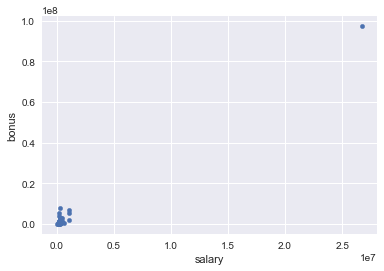

In [3]:
df.plot.scatter(x = 'salary', y = 'bonus')

明显在右上角有一个极为异常的点，奖金和薪水远远高于其他人。

In [4]:
df['salary'].idxmax()

'TOTAL'

结果是‘TOTAL’,那么这个值可能是上市公司的员工总和混入了数据集，下一步将其删除。

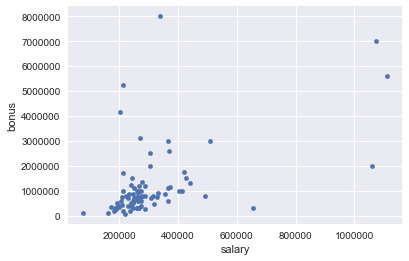

In [5]:
df.drop('TOTAL', inplace = True)
df.plot.scatter(x = 'salary', y = 'bonus')

### 3、特征值选择

我们有to_messages和from_poi_to_this_person这两个特征，因此从感觉上尝试，可以建立一个新的特征命名为 fraction_from_poi，其值为from_poi_to_this_person和to_messages的比值，比值越大也就意味着这个人收到的邮件中来自嫌疑人的邮件越多，往往也就意味着这个人和嫌疑人的关系越密切，很有可能这个人也是一个嫌疑人。另外建立一个特征命名为fraction_to_poi，其值为from_this_person_to_poi和from_messages，比值越大意味这个人会经常给嫌疑人发邮件。

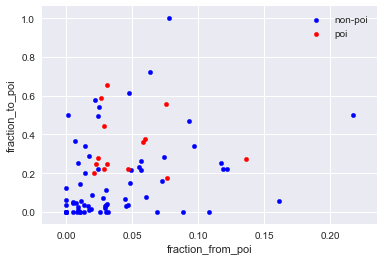

In [6]:
df['fraction_from_poi'] = df['from_poi_to_this_person'] / df['to_messages']
df['fraction_to_poi'] = df['from_this_person_to_poi'] / df['from_messages']

ax = df[df['poi'] == False].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='blue', label='non-poi')
df[df['poi'] == True].plot.scatter(x='fraction_from_poi', y='fraction_to_poi', color='red', label='poi', ax=ax)

从这个新的散点图，发现红色的数据点（POI）聚集在散点图的中心。

### 4.选择和调整算法


为了找到最有效的特征进行分类，使用“决策树”的特征选择重要性排名的功能。选择功能是半手动迭代过程。我先把所有可能的功能为features_list然后开始删除逐一用评分值和人的直觉来回测试特征。

In [7]:
### The first feature must be "poi".
features_list = ['poi', 'salary', 'bonus', 'long_term_incentive', 'deferred_income', 'deferral_payments',
                 'loan_advances', 'other', 'expenses', 'director_fees', 'total_payments', 
                 'exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 
                 'total_stock_value', 'to_messages', 'from_messages', 'from_this_person_to_poi', 
                 'from_poi_to_this_person', 'shared_receipt_with_poi', 'fraction_from_poi', 'fraction_to_poi']

### Load the dictionary containing the dataset
filled_df = df.fillna(value='NaN') # featureFormat expects 'NaN' strings
data_dict = filled_df.to_dict(orient='index')

### Store to my_dataset for easy export below.
my_dataset = data_dict

data = featureFormat(my_dataset, features_list)

labels, features = targetFeatureSplit(data)

### split data into training and testing datasets
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=1)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time
t0 = time()

clf = DecisionTreeClassifier(random_state=2)
clf.fit(features_train,labels_train)
pred= clf.predict(features_test)
print("Accuracy: ", accuracy_score(labels_test, pred))
print("Precision: ", precision_score(labels_test, pred))
print("Recall: ", recall_score(labels_test, pred))

print("Decision tree algorithm time:", round(time()-t0, 3), "s")



importances = clf.feature_importances_
import numpy as np
indices = np.argsort(importances)[::-1]
print('Feature Ranking: ')
for i in range(16):
    print("{} feature {} ({})".format(i+1,features_list[i+1],importances[indices[i]]))

('Accuracy: ', 0.81944444444444442)
('Precision: ', 0.14285714285714285)
('Recall: ', 0.125)
('Decision tree algorithm time:', 0.005, 's')
Feature Ranking: 
1 feature salary (0.193045664013)
2 feature bonus (0.185829912023)
3 feature long_term_incentive (0.165898617512)
4 feature deferred_income (0.132718894009)
5 feature deferral_payments (0.109208689928)
6 feature loan_advances (0.0995391705069)
7 feature other (0.058064516129)
8 feature expenses (0.0556945358789)
9 feature director_fees (0.0)
10 feature total_payments (0.0)
11 feature exercised_stock_options (0.0)
12 feature restricted_stock (0.0)
13 feature restricted_stock_deferred (0.0)
14 feature total_stock_value (0.0)
15 feature to_messages (0.0)
16 feature from_messages (0.0)


实际的效果并不明显，所以我结合个人经验，最终选择10个特征:
"salary", "bonus", "fraction_from_poi", "fraction_to_poi", 'deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value'

In [18]:
features_list2 = ["salary", "bonus", "fraction_from_poi", "fraction_to_poi", 'deferral_payments', \
                 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value']
data2 = featureFormat(my_dataset, features_list2)

 
labels2, features2 = targetFeatureSplit(data2)

### split data into training and testing datasets
from sklearn import cross_validation
features_train2, features_test2, labels_train2, labels_test2 = cross_validation.train_test_split(features2, labels2, test_size=0.5, random_state=1)

t0 = time()

clf = DecisionTreeClassifier(random_state=2)
clf.fit(features_train2,labels_train2)
pred = clf.predict(features_test2)
print("Accuracy: ", accuracy_score(labels_test2, pred))
# print("Precision: ", precision_score(labels_test2, pred))
# print("Recall: ", recall_score(labels_test2, pred))

print("Decision tree algorithm time:", round(time()-t0, 3), "s")

('Accuracy: ', 0.31944444444444442)
('Decision tree algorithm time:', 0.004, 's')


但这些特征的精度和召回率太低（小于0.3），所以我改变策略和手动选择功能，让我的精度和召回率超过0.3。
在这一次使用我的算法精度评价因为只有几个'poi'==1的数据在数据集中，所有最好的评价指标为的准确率和召回率。

在数据集只有18例POI。而有35人是在这次实际事件的涉事人，由于各种原因吧，几乎一半的人都不在该数据集。

最后我选择:
["fraction_from_poi_email", "fraction_to_poi_email", “shared_receipt_with_poi”]

In [8]:
features_list3 = ["poi", "fraction_from_poi", "fraction_to_poi", "shared_receipt_with_poi"]

data3 = featureFormat(my_dataset, features_list3)

labels3, features3 = targetFeatureSplit(data3)

### split data into training and testing datasets
from sklearn import cross_validation
features_train3, features_test3, labels_train3, labels_test3 = cross_validation.train_test_split(features3, labels3, test_size=0.5, random_state=1)

### 4. 算法选择


#### Logistic回归

In [9]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

clf.fit(features_train3,labels_train3)
pred= clf.predict(features_test3)
print("Accuracy: ", accuracy_score(labels_test3, pred))
print("Precision: ", precision_score(labels_test3, pred))
print("Recall: ", recall_score(labels_test3, pred))

print("Logistic Regression algorithm time:", round(time()-t0, 3), "s")

('Accuracy: ', 0.7441860465116279)
('Precision: ', 0.0)
('Recall: ', 0.0)
('Logistic Regression algorithm time:', 638.151, 's')


d:\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


#### 决策树

In [10]:

t0 = time()

clf = DecisionTreeClassifier(random_state=4)
clf.fit(features_train3,labels_train3)
pred= clf.predict(features_test3)
print("Accuracy: ", accuracy_score(labels_test3, pred))
print("Precision: ", precision_score(labels_test3, pred))
print("Recall: ", recall_score(labels_test3, pred))

print("Decision tree algorithm time:", round(time()-t0, 3), "s")

('Accuracy: ', 0.69767441860465118)
('Precision: ', 0.33333333333333331)
('Recall: ', 0.18181818181818182)
('Decision tree algorithm time:', 0.004, 's')



#### 朴素贝叶斯

In [11]:
t0 = time()

clf = GaussianNB()
clf.fit(features_train3, labels_train3)
pred = clf.predict(features_test3)
print("Accuracy: ", accuracy_score(labels_test3, pred))
print("Precision: ", precision_score(labels_test3, pred))
print("Recall: ", recall_score(labels_test3, pred))

print("NB algorithm time:", round(time()-t0, 3), "s")

('Accuracy: ', 0.7441860465116279)
('Precision: ', 0.0)
('Recall: ', 0.0)
('NB algorithm time:', 0.004, 's')


#### 算法调整

In [17]:
t0 = time()
param_grid = {
         'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
          'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
            'max_features': range(3,5)
          }
clf = GridSearchCV(DecisionTreeClassifier(), param_grid)
clf = clf.fit(features_train, labels_train)
print "Best estimator found by grid search:"
print clf.best_estimator_
print 'Running time: ', round(time()-t0, 3), 's'

Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=3, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Running time:  0.693 s


使用逻辑回归、朴素贝叶斯、决策树算法 分别为0.74、0.69和0.74

### 5.验证

In [19]:
# 特征列表
features_list = ["poi", "fraction_from_poi", "fraction_to_poi", "shared_receipt_with_poi"]

# 保存经过预处理的数据集
my_dataset = data_dict

# 原数据集为字典类型，python字典不能直接读入到sklearn分类或回归算法中，我编写了一些辅助函数`featureFormat()`，
# 它可以获取特征名的列表和数据字典，然后返回`numpy`数组,如果特征没有某个特定人员的值(即NaN)，此函数还会用 0替换特征值。
data = featureFormat(my_dataset, features_list)

# 分开类标号和特征
labels, features = targetFeatureSplit(data)


# 交叉验证
from sklearn import cross_validation
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.5, random_state=1)

### use KFold for split and validate algorithm
from sklearn.cross_validation import KFold
kf=KFold(len(labels),3)
for train_indices, test_indices in kf:
    # make training and testing sets
    features_train= [features[ii] for ii in train_indices]
    features_test= [features[ii] for ii in test_indices]
    labels_train=[labels[ii] for ii in train_indices]
    labels_test=[labels[ii] for ii in test_indices]

    
# 决策树
from sklearn.tree import DecisionTreeClassifier

t0 = time()

clf = DecisionTreeClassifier(random_state=0)
clf.fit(features_train,labels_train)
score = clf.score(features_test,labels_test)
print('accuracy before tuning ', score)

print("Decision tree algorithm time:", round(time()-t0, 3), "s")

### use manual tuning parameter min_samples_split
t0 = time()
clf2 = DecisionTreeClassifier(min_samples_split=5, random_state=0)
clf2 = clf2.fit(features_train,labels_train)
pred2 = clf2.predict(features_test)
print("done in %0.3fs" % (time() - t0))

print("Validating algorithm:")
print("accuracy after tuning = ", accuracy_score(labels_test, pred2))
print('precision = ', precision_score(labels_test,pred2))
print('recall = ', recall_score(labels_test,pred2))
#############################################################################



### dump your classifier, dataset and features_list so
### anyone can run/check your results
pickle.dump(clf, open("my_classifier.pkl", "wb") )
pickle.dump(data_dict, open("my_dataset.pkl", "wb") )
pickle.dump(features_list, open("my_feature_list.pkl", "wb"))

('accuracy before tuning ', 0.8928571428571429)
('Decision tree algorithm time:', 0.001, 's')
done in 0.001s
Validating algorithm:
('accuracy after tuning = ', 0.9285714285714286)
('precision = ', 0.66666666666666663)
('recall = ', 0.66666666666666663)


验证是一种模型验证技术，用于评估统计分析的结果如何推广到独立的数据集。我经常犯的经典错误是过度拟合模型; 因此，过度拟合模型在训练数据上表现良好，但在预测新的或不可见的数据时通常会大幅失败。

### 6.使用tester.py的测试结果


  "This module will be removed in 0.20.", DeprecationWarning)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')
        Accuracy: 0.85589       Precision: 0.35977      Recall: 0.38100 F1: 0.37008     F2: 0.37656
        Total predictions: 9000 True positives:  381    False positives:  678   False negatives:  619   True negatives: 7322

Precision: 0.35977      Recall: 0.38100  都超过了项目要求。


### 7.结论

精度可以被解释为，一个人被确定为一个POI实际上是一个真正的POI的可能性。召回率，标识将在测试集的POI标志的可能性有多大。召回0.38意味着在数据集中存在的100个真实POI中，38个POI被正确地分类为POI。

精度可以被解释为一个人被确定POI可能性，但现实生活中，我们很难获取财务数据，这说明很难使用该模型去识别欺诈行为。改进的可能路径之一是挖掘的更多电子邮件数据。在该数据集的电子邮件特征汇总了所有的电子邮件数量，并没有挖掘电子邮件的具体内容，如果通过挖掘每个人的邮件的文本，使用特定的语义分析，例如，特定词汇的使用/信息，就可以实现识别欺诈行为。